TabTransformer is a deep tabular data modeling architecture for supervised and semi-supervised learning. The TabTransformer is built upon self-attention based Transformers. The Transformer layers transform the embeddings of categorical features into robust contextual embeddings to achieve higher predictive accuracy.

# Importing packages and reading in the csv file

In [126]:
import numpy as np
import pandas as pd
import math

from functools import partial
import matplotlib.pyplot as plt

from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

import tensorflow as tf
from tensorflow import keras
from tensorflow import data as tf_data
from keras import layers
from keras import ops
from keras import Model
from keras.layers import Dense, Embedding, Input, Dropout, BatchNormalization, Flatten, Attention, GroupQueryAttention, MultiHeadAttention, AdditiveAttention
from keras.metrics import AUC, Precision, Recall, F1Score
from keras.losses import BinaryCrossentropy, BinaryFocalCrossentropy
from keras.optimizers import Adam, RMSprop, Adadelta, Adagrad, AdamW, Adamax

In [127]:
X_train = pd.read_csv("./tt_data/X_train_tt.csv")
y_train = pd.read_csv("./tt_data/y_train_tt.csv")
X_test = pd.read_csv("./tt_data/X_test_tt.csv")
y_test = pd.read_csv("./tt_data/y_test_tt.csv")
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
X_train

(423, 35)
(106, 35)
(423, 1)
(106, 1)


,Age (yrs),BMI,Pulse rate(bpm),RR (breaths/min),Hb(g/dl),Menstrual Cycle Length(days),Marriage Status (Yrs),Pregnant(Y/N),No. of abortions,I beta-HCG(mIU/mL),...,Reg.Exercise(Y/N),BP _Systolic (mmHg),BP _Diastolic (mmHg),Follicle No. (L),Follicle No. (R),Avg. F size (L) (mm),Avg. F size (R) (mm),Endometrium (mm),Blood Group,Menstrual Cycle(R/I)
0,38,29.0,78,20,12.9,2,16.0,1,1,110.17,...,0,110,70,12,12,17.0,9.0,11.30,A+,irregular
1,38,21.3,72,18,12.5,5,14.0,0,0,1.99,...,0,110,70,4,1,17.0,13.0,6.50,B+,regular
2,35,21.4,72,20,12.0,6,13.0,1,0,2045.30,...,0,140,70,3,5,10.0,11.0,5.00,A+,regular
3,29,19.6,80,20,11.1,5,2.0,1,0,8104.21,...,0,110,70,6,5,20.0,20.0,5.60,B+,regular
4,37,29.0,80,22,11.2,5,14.0,0,0,1.99,...,1,120,80,3,3,21.0,18.0,9.30,O+,regular
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
418,29,29.3,72,18,12.0,5,9.0,0,0,1.99,...,1,110,70,1,1,12.0,14.0,9.50,O+,irregular
419,27,23.1,82,20,11.1,5,5.0,0,0,1.99,...,1,120,80,1,1,16.0,17.0,8.55,A+,regular
420,35,22.5,74,20,11.1,4,15.0,1,1,1.99,...,0,110,70,3,3,18.0,18.0,7.00,B+,regular
421,36,25.3,72,18,11.8,2,10.0,0,0,1.99,...,0,120,70,8,6,13.0,15.0,8.50,A+,irregular


# Renaming columns that contain '/'

In [128]:
naming_dic = {'Menstrual Cycle(R/I)': 'Menstrual Cycle(R or I)', 'Weight gain(Y/N)': 'Weight gain', 
'hair growth(Y/N)': 'hair growth', 'Skin darkening (Y/N)': 'Skin darkening', 'Hair loss(Y/N)': 'Hair loss', 
'Pimples(Y/N)': 'Pimples', 'Fast food (Y/N)': 'Fast food', 'Reg.Exercise(Y/N)': 'Reg.Exercise',
'Pregnant(Y/N)': 'Pregnant', 'RR (breaths/min)': 'RR (breaths per min)', 'Hb(g/dl)': 'Hb(g per dl)',
'I   beta-HCG(mIU/mL)': 'I   beta-HCG(mIU per mL)', 'II    beta-HCG(mIU/mL)': 'II    beta-HCG(mIU per mL)',
'FSH/LH': 'FSH:LH ratio', 'TSH (mIU/L)': 'TSH (mIU per L)', 'AMH(ng/mL)': 'AMH(ng per mL)', 
'PRL(ng/mL)': 'PRL(ng per mL)', 'Vit D3 (ng/mL)': 'Vit D3 (ng per mL)', 'PRG(ng/mL)': 'PRG(ng per mL)', 
'RBS(mg/dl)': 'RBS(mg per dl)'}

X_train.rename(columns=naming_dic, inplace=True)
X_test.rename(columns=naming_dic, inplace=True)
print(X_train.columns)
print("\n")
print(X_test.columns)

Index(['Age (yrs)', 'BMI', 'Pulse rate(bpm)', 'RR (breaths per min)',
       'Hb(g per dl)', 'Menstrual Cycle Length(days)', 'Marriage Status (Yrs)',
       'Pregnant', 'No. of abortions', 'I   beta-HCG(mIU per mL)',
       'II    beta-HCG(mIU per mL)', 'FSH:LH ratio', 'Waist:Hip Ratio',
       'TSH (mIU per L)', 'AMH(ng per mL)', 'PRL(ng per mL)',
       'Vit D3 (ng per mL)', 'PRG(ng per mL)', 'RBS(mg per dl)', 'Weight gain',
       'hair growth', 'Skin darkening', 'Hair loss', 'Pimples', 'Fast food',
       'Reg.Exercise', 'BP _Systolic (mmHg)', 'BP _Diastolic (mmHg)',
       'Follicle No. (L)', 'Follicle No. (R)', 'Avg. F size (L) (mm)',
       'Avg. F size (R) (mm)', 'Endometrium (mm)', 'Blood Group',
       'Menstrual Cycle(R or I)'],
      dtype='object')


Index(['Age (yrs)', 'BMI', 'Pulse rate(bpm)', 'RR (breaths per min)',
       'Hb(g per dl)', 'Menstrual Cycle Length(days)', 'Marriage Status (Yrs)',
       'Pregnant', 'No. of abortions', 'I   beta-HCG(mIU per mL)',
       'I

# Changing column types

In [129]:
X_train["Fast food"] = X_train["Fast food"].astype("int64")
X_test["Fast food"] = X_test["Fast food"].astype("int64")

In [130]:
CATEGORICAL_FEATURE_NAMES = ['Blood Group', 'Menstrual Cycle(R or I)', 'Weight gain', 
'hair growth', 'Skin darkening', 'Hair loss', 'Pimples',
'Fast food', 'Reg.Exercise', 'Pregnant']
num_cols = [col for col in X_train.columns if col not in CATEGORICAL_FEATURE_NAMES]
for col in num_cols:
    X_train[col] = X_train[col].astype("float32")
    X_test[col] = X_test[col].astype("float32")

# Finding the class weights to resolve the issue of class imbalance

In [131]:
df = pd.concat([y_train, y_test], axis=0)
df 

,PCOS (Y/N)
0,1
1,0
2,0
3,0
4,0
...,...
101,0
102,0
103,0
104,0


In [132]:
target_counts = np.bincount(df["PCOS (Y/N)"])
weight_for_0 = 1.0/target_counts[0]
weight_for_1 = 1.0/target_counts[1]

# Changing the integers in categorical columns to strings

In [133]:
cols = ['Weight gain', 'hair growth', 'Skin darkening', 'Hair loss', 'Pimples','Fast food', 'Reg.Exercise', 'Pregnant']
for col in cols:
    X_train[col] = X_train[col].apply(lambda x: "Yes" if x==1 else "No")
    X_test[col] = X_test[col].apply(lambda x: "Yes" if x==1 else "No")

# Sets a random seed to ensure reproducible results

In [134]:
seed_value= 0

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
tf.random.set_seed(seed_value)
# for later versions: 
# tf.compat.v1.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
"""
from keras import backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)"
"""

'\nfrom keras import backend as K\nsession_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)\nsess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)\ntf.compat.v1.keras.backend.set_session(sess)"\n'

# Splitting into train, validation and test datasets

In [135]:
# Choose either 60, 20, 20 or 80, 10, 10
# Depends on the complexity of the model, the dataset size and the nature of the data

test_size = 0.25
random_state = 1

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=test_size, stratify=y_train, random_state=random_state)

In [136]:
# Needs to sort the columns properly so that the model can read in the inputs correctly
"""
training_data_tt = pd.concat([X_train, y_train], axis=1).reindex(sorted(df.columns), axis=1)
training_data_tt.to_csv("./tt_data/training_data_tt.csv", index=False)

val_data_tt = pd.concat([X_val, y_val], axis=1).reindex(sorted(df.columns), axis=1)
val_data_tt.to_csv("./tt_data/val_data_tt.csv", index=False)

test_data_tt = pd.concat([X_test, y_test], axis=1).reindex(sorted(df.columns), axis=1)
test_data_tt.to_csv("./tt_data/test_data_tt.csv", index=False)
"""

training_data_tt = pd.concat([X_train, y_train], axis=1)
training_data_tt.to_csv("./tt_data/training_data_tt.csv", index=False)

val_data_tt = pd.concat([X_val, y_val], axis=1)
val_data_tt.to_csv("./tt_data/val_data_tt.csv", index=False)

test_data_tt = pd.concat([X_test, y_test], axis=1)
test_data_tt.to_csv("./tt_data/test_data_tt.csv", index=False)

# Define dataset metadata

In [137]:
TRAIN_DATA_FILE = "./tt_data/training_data_tt.csv"
VAL_DATA_FILE = "./tt_data/val_data_tt.csv"
TEST_DATA_FILE = "./tt_data/test_data_tt.csv"
training_data_tt = pd.read_csv(TRAIN_DATA_FILE)

CATEGORICAL_FEATURE_NAMES = ['Blood Group', 'Menstrual Cycle(R or I)', 'Weight gain', 
'hair growth', 'Skin darkening', 'Hair loss', 'Pimples',
'Fast food', 'Reg.Exercise', 'Pregnant']
CATEGORICAL_FEATURES_WITH_VOCABULARY = {col:sorted(list(X_train[col].unique())) for col in CATEGORICAL_FEATURE_NAMES}
NUMERIC_FEATURE_NAMES = [col for col in X_train.columns if col not in CATEGORICAL_FEATURE_NAMES]
TARGET_COLUMN = "PCOS (Y/N)"
#TARGET_LABELS = ["Yes", "No"]
FEATURE_NAMES = [col for col in list(training_data_tt.columns) if col!=TARGET_COLUMN]

# Configure the hyperparameters

In [138]:
# Includes model architecture and training configurations
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
DROPOUT_RATE = 0.2
BATCH_SIZE = 64
NUM_EPOCHS = 6

NUM_TRANSFORMER_BLOCKS = 1
NUM_HEADS = 4 #Number of attention heads
EMBEDDING_DIMS = 16 # Embedding dimensions of the categorical features
MLP_HIDDEN_UNITS_FACTORS = [2,1]
NUM_MLP_BLOCKS = 2

# Implement a data reading pipeline

In [139]:
# Creating lookup
#target_label_lookup = layers.StringLookup(vocabulary=TARGET_LABELS, mask_token=None, num_oov_indices=0)
lookup_dic={}
for col in CATEGORICAL_FEATURE_NAMES:
    vocab = CATEGORICAL_FEATURES_WITH_VOCABULARY[col]
    lookup = layers.StringLookup(vocabulary=vocab, mask_token=None, num_oov_indices=0)
    lookup_dic[col] = lookup

def prepare_example(features, target):
    #target_idx = target_label_lookup(target)
    return features, target

def encode_categorical(batch_x, batch_y):
    for col in CATEGORICAL_FEATURE_NAMES:
        if col in batch_x:
            batch_x[col] = lookup_dic[col](batch_x[col])
    return batch_x, batch_y

def get_dataset_from_csv(csv_file_path, batch_size=128, shuffle=False):
    dataset = (
        tf_data.experimental.make_csv_dataset(
            csv_file_path,
            batch_size=batch_size,
            label_name=TARGET_COLUMN,
            num_epochs=1,
            header=True,
            shuffle=shuffle,
        )
        .map(prepare_example, num_parallel_calls=tf_data.AUTOTUNE, deterministic=False)
        .map(encode_categorical)
    )
    return dataset.cache()

# Implement a training and evaluation procedure

In [140]:
my_callbacks = [
    #keras.callbacks.EarlyStopping(patience=5, min_delta=0.005),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5)]

In [141]:
def run_experiment(model, train_data_file, val_data_file, test_data_file, learning_rate, weight_decay, batch_size, num_epoch, weight_for_0, weight_for_1):
    train_dataset = get_dataset_from_csv(train_data_file, batch_size, shuffle=True)
    validation_dataset = get_dataset_from_csv(val_data_file, batch_size)
    test_dataset = get_dataset_from_csv(test_data_file, batch_size)
    y_true = np.concatenate([y.numpy() for _, y in test_dataset])
    model.compile(loss= BinaryCrossentropy() , optimizer=Adam(learning_rate=learning_rate, weight_decay=weight_decay) , metrics=[AUC]) 
    print("Start training the model...")
    history = model.fit(train_dataset, epochs=num_epoch, validation_data=validation_dataset, batch_size=batch_size, verbose=2, class_weight={0: weight_for_0, 1: weight_for_1}, callbacks=my_callbacks)
    print("Model training finished")
    test_loss, test_auc = model.evaluate(test_dataset, verbose=2)
    print(f"Test ROC AUC: {round(test_auc * 100, 2)}%")
    test_pred = model.predict(test_dataset, verbose=2).ravel()
    return history, y_true, test_pred, test_auc

# Create model inputs

In [142]:
from collections import OrderedDict

def create_model_inputs():
    inputs=OrderedDict() 
    # If the dictionary is ordered, the Model will not sort the dictionary so it can read in the inputs correctly
    for feature_name in FEATURE_NAMES:
        if feature_name in CATEGORICAL_FEATURE_NAMES:
            inputs[feature_name] = Input(shape=(), dtype="int64", name=feature_name)
        else:
            inputs[feature_name] = Input(shape=(), dtype="float32", name=feature_name)
    return inputs

# Encode features

In [143]:
def encode_inputs(inputs, embedding_dims):
    encoded_categorical_feature_list = []
    numerical_feature_list = []
    for feature_name in inputs:
        if feature_name in CATEGORICAL_FEATURE_NAMES:
            vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY[feature_name]
            embedding = Embedding(input_dim=len(vocabulary), output_dim=embedding_dims)
            encoded_categorical_feature = embedding(inputs[feature_name]) # shape:(None, embedding_dims)
            encoded_categorical_feature_list.append(encoded_categorical_feature)
        else:
            numerical_feature = ops.expand_dims(inputs[feature_name], axis=-1) # shape:(None, 1)
            numerical_feature_list.append(numerical_feature)
    return encoded_categorical_feature_list, numerical_feature_list

# Implement an MLP block

In [144]:
def create_mlp(input, hidden_units, dropout_rate, activation, normalization_layer, name=None):
    inputs = Input(shape=input.shape[1:])
    x = inputs
    for units in hidden_units:
        x = normalization_layer()(x)
        x = Dense(units, activation=activation)(x)
        x = Dropout(dropout_rate)(x)
    outputs = x
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Implement the TabTransformer classifier

1. All the categorical features are encoded as embeddings, using the same embedding_dims. This means that each value in each categorical feature will have its own embedding vector.
2. A column embedding, one embedding vector for each categorical feature, is added (point-wise) to the categorical feature embedding.
3. The embedded categorical features are fed into a stack of Transformer blocks. Each Transformer block consists of a multi-head self-attention layer followed by a feed-forward layer.
4. The outputs of the final Transformer layer, which are the contextual embeddings of the categorical features, are concatenated with the input numerical features, and fed into a final MLP block.
5. A softmax classifer is applied at the end of the model.

In [145]:
def create_tabtransformer_classifier(num_transformer_blocks, num_heads, embedding_dims, mlp_hidden_units_factors, dropout_rate, use_column_embedding=False):
    # Create model inputs
    inputs = create_model_inputs()
    # Encode features
    encoded_categorical_feature_list, numerical_feature_list = encode_inputs(inputs, embedding_dims)
    # Stack categorical feature embeddings for the Transformer
    encoded_categorical_features = ops.stack(encoded_categorical_feature_list, axis=1) # shape:(None, num_cat_cols, embedding_dims)
    # Concatenate numerical features
    numerical_features = layers.concatenate(numerical_feature_list) # shape: (None, num_numerical_cols)
    # Add column embedding to categorical feature embeddings
    if use_column_embedding:
        num_cat_columns = encoded_categorical_features.shape[1]
        column_embedding = Embedding(input_dim=num_cat_columns, output_dim=embedding_dims)
        column_indices = ops.arange(start=0, stop=num_cat_columns, step=1)
        encoded_categorical_features = encoded_categorical_features + column_embedding(column_indices) # shape: (None, num_cat_cols, embedding_dims)
    
    # Create multiple layers of the Transformer block
    for block_idx in range(num_transformer_blocks):
        # Create a multi-head attention layer
        attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dims, dropout=dropout_rate, name=f"multihead_attention_{block_idx}")(encoded_categorical_features, encoded_categorical_features) # shape: (None, num_cat_cols, embedding_dims)
        # Skip connection 1
        x = layers.Add(name=f"skip_connection1_{block_idx}")([attention_output, encoded_categorical_features]) # shape: (None, num_cat_cols, embedding_dims)
        # Layer normalization 1
        x = layers.LayerNormalization(name=f"layer_norm1_{block_idx}", epsilon=1e-6)(x)
        # Feedforward
        feedforward_output = create_mlp(input=x, hidden_units=[embedding_dims], dropout_rate=dropout_rate, activation=keras.activations.gelu, normalization_layer=layers.LayerNormalization, name=f"feedforward_{block_idx}")(x) # Using partial to provide keyword arguments before initialization
        # normalization_layer=partial(layers.LayerNormalization, epsilon=1e-6)
        # Skip connection 2
        x = layers.Add(name=f"skip_connection2_{block_idx}")([feedforward_output, x])
        # Layer normalization 2
        encoded_categorical_features = layers.LayerNormalization(name=f"layer_norm2_{block_idx}", epsilon=1e-6)(x)
    
    # Flatten the "contextualized" embeddings of the categorical features
    categorical_features = layers.Flatten()(encoded_categorical_features) # shape: (None, num_cat_cols*embedding_dims)
    # Apply layer normalization to the numerical features
    numerical_features = layers.LayerNormalization(epsilon=1e-6)(numerical_features)
    # Prepare the input for the final MLP block
    features = layers.concatenate([categorical_features, numerical_features]) # shape: (None,  num_cat_cols*embedding_dims+num_numerical_cols)

    # Compute MLP hidden units
    mlp_hidden_units = [factor*features.shape[-1] for factor in mlp_hidden_units_factors]
    # Create final MLP
    features = create_mlp(input=features, hidden_units=mlp_hidden_units, dropout_rate=dropout_rate, activation=keras.activations.selu, normalization_layer=layers.BatchNormalization, name="MLP")(features) # shape: (None,  num_cat_cols*embedding_dims+num_numerical_cols)

    # Add a sigmoid as a binary classifier
    outputs = Dense(1, "sigmoid", name="sigmoid")(features)
    model = Model(inputs, outputs)
    return model

tabtransformer_model = create_tabtransformer_classifier(NUM_TRANSFORMER_BLOCKS, NUM_HEADS, EMBEDDING_DIMS, MLP_HIDDEN_UNITS_FACTORS, DROPOUT_RATE, True)
print("Total model weights:", tabtransformer_model.count_params())

Total model weights: 144999


# Training and evaluation

In [146]:
history, y_true, y_pred, test_auc = run_experiment(tabtransformer_model, TRAIN_DATA_FILE, VAL_DATA_FILE, TEST_DATA_FILE, LEARNING_RATE, WEIGHT_DECAY, BATCH_SIZE, NUM_EPOCHS, weight_for_0, weight_for_1)

Start training the model...
Epoch 1/6


c:\Users\Stacy\anaconda\envs\dsa4262_pcos\Lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


5/5 - 7s - 1s/step - auc_4: 0.8038 - loss: 0.0027 - val_auc_4: 0.9189 - val_loss: 0.4184 - learning_rate: 1.0000e-03
Epoch 2/6
5/5 - 0s - 19ms/step - auc_4: 0.8881 - loss: 0.0018 - val_auc_4: 0.9028 - val_loss: 0.3987 - learning_rate: 1.0000e-03
Epoch 3/6
5/5 - 0s - 21ms/step - auc_4: 0.8983 - loss: 0.0016 - val_auc_4: 0.9030 - val_loss: 0.4060 - learning_rate: 1.0000e-03
Epoch 4/6
5/5 - 0s - 17ms/step - auc_4: 0.9164 - loss: 0.0014 - val_auc_4: 0.9177 - val_loss: 0.3837 - learning_rate: 1.0000e-03
Epoch 5/6
5/5 - 0s - 19ms/step - auc_4: 0.9261 - loss: 0.0014 - val_auc_4: 0.9252 - val_loss: 0.3521 - learning_rate: 1.0000e-03
Epoch 6/6
5/5 - 0s - 16ms/step - auc_4: 0.9259 - loss: 0.0014 - val_auc_4: 0.9205 - val_loss: 0.3346 - learning_rate: 1.0000e-03
Model training finished
2/2 - 0s - 10ms/step - auc_4: 0.9187 - loss: 0.3609
Test ROC AUC: 91.87%
2/2 - 1s - 550ms/step


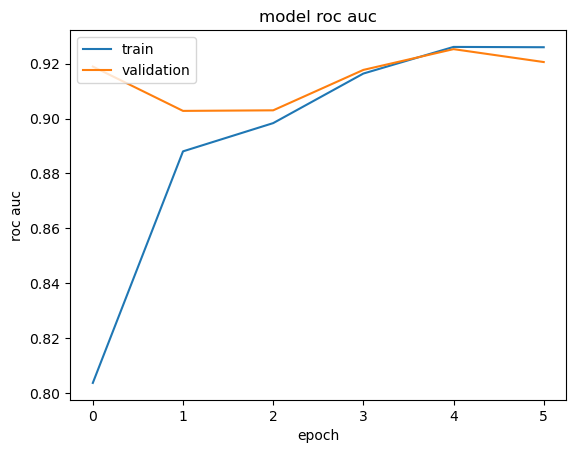

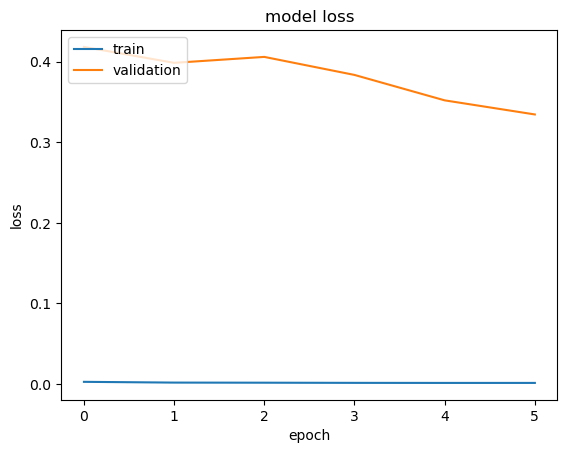

In [147]:
history_keys = list(history.history.keys())

# summarize history for roc auc
plt.plot(history.history[history_keys[0]])
plt.plot(history.history[history_keys[2]])
plt.title('model roc auc')
plt.ylabel('roc auc')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history[history_keys[1]])
plt.plot(history.history[history_keys[3]])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

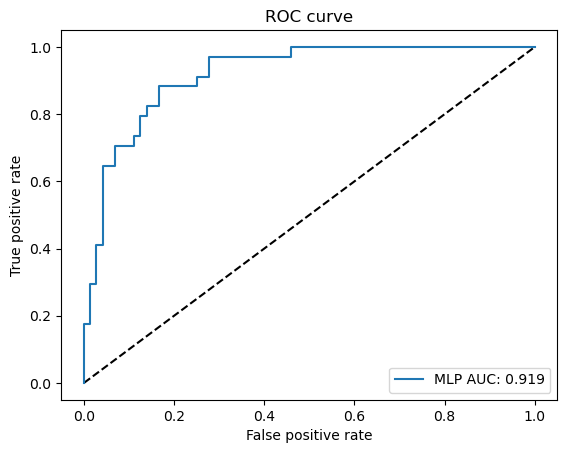

In [148]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_true, y_pred)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='MLP AUC: {:.3f}'.format(test_auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

## Finding the best threshold

In [149]:
# This method minimizes the distance to the top-left corner of the ROC space.
distances = np.sqrt((1 - tpr) ** 2 + fpr ** 2)
best_thresh = thresholds[np.argmin(distances)]
print(f"Best threshold: {best_thresh}")

Best threshold: 0.19801251590251923


Precision: 0.71
Recall: 0.88
Specificity: 0.83
Sensitivity: 0.88


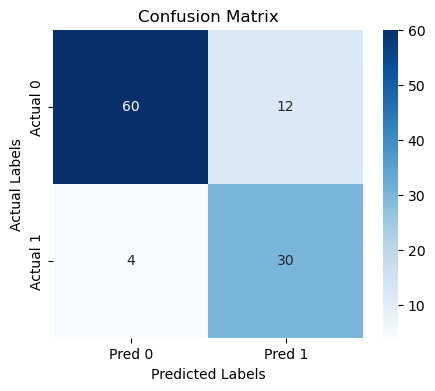

              precision    recall  f1-score   support

           0       0.94      0.83      0.88        72
           1       0.71      0.88      0.79        34

    accuracy                           0.85       106
   macro avg       0.83      0.86      0.84       106
weighted avg       0.87      0.85      0.85       106



In [150]:
from sklearn.metrics import precision_score, recall_score, classification_report, confusion_matrix
import seaborn as sns

y_pred = [1 if prob>=best_thresh else 0 for prob in y_pred]

# Compute Precision and Recall
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')

# Compute Sensitivity and Specificity
specificity = recall_score(y_true, y_pred, pos_label=0)

print(f'Specificity: {specificity:.2f}')
print(f'Sensitivity: {recall:.2f}')

# Visualise the confusion matrix
cm = confusion_matrix(y_true, y_pred)
labels = ["True Negatives (TN)", "False Positives (FP)", "False Negatives (FN)", "True Positives (TP)"]

# Plot confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Pred 0", "Pred 1"], yticklabels=["Actual 0", "Actual 1"])
plt.xlabel("Predicted Labels")
plt.ylabel("Actual Labels")
plt.title("Confusion Matrix")
plt.show()


# Visualise the classification report
report = classification_report(y_true, y_pred)
print(report)

Precision: 0.71
Recall: 0.88
Specificity: 0.83
Sensitivity: 0.88


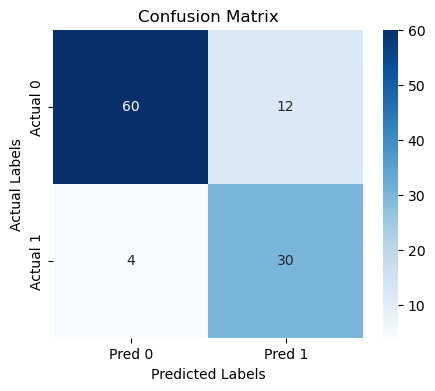

              precision    recall  f1-score   support

           0       0.94      0.83      0.88        72
           1       0.71      0.88      0.79        34

    accuracy                           0.85       106
   macro avg       0.83      0.86      0.84       106
weighted avg       0.87      0.85      0.85       106



In [151]:
from sklearn.metrics import precision_score, recall_score, classification_report, confusion_matrix
import seaborn as sns

y_pred = [1 if prob>=best_thresh else 0 for prob in y_pred]

# Compute Precision and Recall
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')

# Compute Sensitivity and Specificity
specificity = recall_score(y_true, y_pred, pos_label=0)

print(f'Specificity: {specificity:.2f}')
print(f'Sensitivity: {recall:.2f}')

# Visualise the confusion matrix
cm = confusion_matrix(y_true, y_pred)
labels = ["True Negatives (TN)", "False Positives (FP)", "False Negatives (FN)", "True Positives (TP)"]

# Plot confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Pred 0", "Pred 1"], yticklabels=["Actual 0", "Actual 1"])
plt.xlabel("Predicted Labels")
plt.ylabel("Actual Labels")
plt.title("Confusion Matrix")
plt.show()


# Visualise the classification report
report = classification_report(y_true, y_pred)
print(report)